# Tariff recommendation

We have the data on the behavior of customers who have already switched to these tariffs. Need to build a model for the classification problem that will select the appropriate tariff.

Need to build the model with the largest possible *accuracy* value. The model need to demonstrate the percentage of correct answers (accuracy) to at least 0.75.

## Open and explore the file

In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [2]:
df = pd.read_csv('/content/users_behavior.csv')

In [3]:
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


The data according to the task condition is initially preprocessed, there are no gaps, we can proceed to building models.

## Split the data into samples

It is necessary to divide the sample into three parts - training, validation and test. We will split in the ratio 3/1/1 by successively applying 'train_test_split':

In [5]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [6]:
train_features, test_features, train_target, test_target = train_test_split(
features, target, test_size=0.4, random_state=12345)

In [7]:
valid_features, test_features, valid_target, test_target = train_test_split(
test_features, test_target, test_size=0.5, random_state=12345)

We have three sets of data:

In [8]:
[[train_features.shape, train_target.shape], [valid_features.shape, valid_target.shape], \
 [test_features.shape, test_target.shape]]

[[(1928, 4), (1928,)], [(643, 4), (643,)], [(643, 4), (643,)]]

## Model research

We will choose the model type from three options: DecisionTree, RandomForest, LogisticRegression. We will also find the optimal hyperparameters for tree models:

In [9]:
best_model = None
best_result = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(train_features, train_target)
    predictions = model.predict(valid_features)
    result = accuracy_score(valid_target, predictions)
    if result > best_result:
        best_model = model
        best_result = result
print(best_model)
print(best_result)

DecisionTreeClassifier(max_depth=3, random_state=12345)
0.7853810264385692


In [10]:
best_model = None
best_result = 0
for est in tqdm(range(1, 61)):
    for depth in range(1, 6):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(train_features, train_target)
        result = model.score(valid_features, valid_target)
        if result > best_result:
            best_model = model
            best_result = result

print(best_result)
print(best_model)

100%|██████████| 60/60 [00:37<00:00,  1.61it/s]

0.7947122861586314
RandomForestClassifier(max_depth=5, n_estimators=40, random_state=12345)


In [11]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(train_features, train_target)
model.score(valid_features, valid_target)

0.7589424572317263

All types of models showed accuracy > 0.75. The best result was shown by the RandomForestClassifier model with max_depth=5 and n_estimators=40.

## Let's check the model on the test set

Let's check the best of the considered models on a test sample:

In [12]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [13]:
model.fit(train_features, train_target)
model.score(test_features, test_target)

0.7838258164852255

The accuracy of the model on the test set approximately corresponds to the accuracy obtained earlier, which means that the model has trained normally and is suitable for use.

## Checking the model for adequacy

Let's determine the shares of classes in the available data:

In [14]:
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

In [15]:
train_target.value_counts(normalize=True)

0    0.692427
1    0.307573
Name: is_ultra, dtype: float64

In [16]:
test_target.value_counts(normalize=True)

0    0.684292
1    0.315708
Name: is_ultra, dtype: float64

Fill in Dummy with the value of interest (in our case, 1, because we are interested in offering the Ultra tariff)

In [17]:
dummy_clf = DummyClassifier(random_state=12345, strategy='constant', constant=1)

In [18]:
dummy_clf.fit(train_features, train_target)

DummyClassifier(constant=1, random_state=12345, strategy='constant')

In [19]:
d_predict = dummy_clf.predict(test_features)

In [20]:
prediction = model.predict(test_features)

In [21]:
cm = confusion_matrix(test_target, prediction, normalize='all')

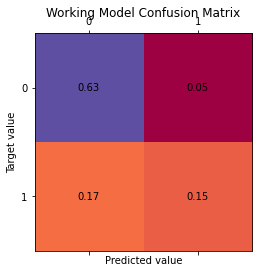

In [22]:
fig, ax = plt.subplots()
ax.matshow(cm, cmap='Spectral')
plt.title('Working Model Confusion Matrix')
plt.xlabel('Predicted value')
plt.ylabel('Target value')
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.show()

Now let's look at 'precision', 'recall' and 'f-score' for both models:

In [23]:
precision_recall_fscore_support(test_target, prediction, average='binary')

(0.75, 0.4729064039408867, 0.5800604229607251, None)

In [24]:
precision_recall_fscore_support(test_target, d_predict, average='binary')

(0.3157076205287714, 1.0, 0.47990543735224583, None)

In [25]:
dummy_clf.score(test_features, test_target)

0.3157076205287714

In [26]:
model.score(test_features, test_target)

0.7838258164852255

As a result, we see that the model, in principle, works normally. The relatively low 'recall' is due to class imbalance in the training data.